### Load models


In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import rc

sys.path.append("../")
# Import dataloaders
import data_utils.ood_detection.cifar10 as cifar10
import data_utils.ood_detection.cifar100 as cifar100
import data_utils.ood_detection.lsun as lsun
import data_utils.ood_detection.svhn as svhn
import data_utils.ood_detection.mnist as mnist
import data_utils.ood_detection.tiny_imagenet as tiny_imagenet

# Network architectures
from net.lenet import lenet
from net.resnet import resnet50
from net.vgg import vgg16
from net.wide_resnet import wrn

from utils.gmm_utils import get_embeddings, gmm_evaluate, gmm_fit, maxp_evaluate, gmm_evaluate_with_perturbation, maxp_evaluate_with_perturbation
from metrics.uncertainty_confidence import entropy, logsumexp, confidence, sumexp
from metrics.ood_metrics import get_roc_auc, get_roc_auc_logits

In [9]:
device = torch.device("cuda:0")
# Dataset params
dataset_num_classes = {"cifar10": 10, "cifar100": 100, "svhn": 10, "lsun": 10, "tiny_iamgenet": 200}
dataset_loader = {"cifar10": cifar10, "cifar100": cifar100, "SVHN": svhn, "mnist": mnist, "LSUN": lsun, "tiny_imagenet": tiny_imagenet}

# Mapping model name to model function
models = {
    "lenet": lenet,
    "resnet50": resnet50,
    "wide_resnet": wrn,
    "vgg16": vgg16,
}

model_to_num_dim = {"resnet18": 512, "resnet50": 2048, "resnet101": 2048, "resnet152": 2048, "wide_resnet": 640, "vgg16": 512}

batch_size = 256
dataset = "cifar10"
ood_dataset = "LSUN"
dataset_root = "../data"
# model = "vgg16"
# saved_model_name = "../saved_models/run17/vgg16_sn_3.0_mod_seed_1/2024_05_27_17_51_26/vgg16_sn_3.0_mod_seed_1_best.model"

model = "resnet50"
saved_model_name = "../saved_models/run17/resnet50_sn_3.0_mod_seed_1/2024_05_21_12_30_21/resnet50_sn_3.0_mod_seed_1_best.model"

# Taking input for the dataset
num_classes = dataset_num_classes[dataset]
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=batch_size)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=batch_size)

In [10]:
#load model
print(f"load {saved_model_name}")
net = models[model](
    spectral_normalization=True,
    mod=True,
    num_classes=num_classes,
    temp=1.0,
).to(device)

_  = net.load_state_dict(torch.load(str(saved_model_name), map_location=device), strict=True)
_ = net.eval()

load ../saved_models/run17/resnet50_sn_3.0_mod_seed_1/2024_05_21_12_30_21/resnet50_sn_3.0_mod_seed_1_best.model


In [11]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 2.5})

rc('text', usetex=False)


def plot_activation(data1, data2, title1, title2):
    # 使用matplotlib绘制特征图
    fig, axes = plt.subplots(2, 1)
    plt.tight_layout()
    minv = np.min(data1)
    maxv = np.max(data1)

    im1 = axes[0].imshow(data1, cmap='viridis')  # cmap参数指定色彩映射
    axes[0].set_title(title1)
    im1.set_clim(minv, maxv)
    im2 = axes[1].imshow(data2, cmap='viridis')  # cmap参数指定色彩映射
    im2.set_clim(minv, maxv)
    axes[1].set_title(title2)

    fig.colorbar(im1, ax=axes)


if not os.path.exists(f"pngs/{model}/"):
    os.makedirs(f"pngs/{model}/")

In [5]:
train_loader, val_loader = dataset_loader[dataset].get_train_valid_loader(
    root=dataset_root,
    batch_size=512,
    augment=True,
    val_seed=1,
    val_size=0.1,
)
embeddings, labels, norm = get_embeddings(
    net,
    train_loader,
    num_dim=model_to_num_dim[model],
    dtype=torch.double,
    device=device,
    storage_device=device,
)
gaussians_model, jitter_eps = gmm_fit(embeddings=embeddings, labels=labels, num_classes=num_classes)

get embeddings from dataloader...


100%|██████████| 88/88 [00:17<00:00,  5.15it/s]


### GradNorm wrt Input


In [6]:
def calculate_gradients_activation(
    net,
    gaussians_model,
    layer_name,
    loader,
    device,
    wrt="input",
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010],
    norm=1,
):
    layer_grad = None

    def bp_hook(module, grad_input, grad_output):
        # 获取中间层梯度信息
        nonlocal layer_grad
        input_grad = grad_input[0]
        w_grad = grad_input[1]
        # input_grad = grad_input[2]#TODO: 当使用sn时，conv层的bias都为false，这时候这样的,当bias为true时候，需要再次验证???
        if wrt == "input":
            layer_grad = input_grad  #1-norm
        elif wrt == "weight":
            layer_grad = w_grad
        else:
            raise ValueError(f"{wrt} is invalid...")

    grads = []

    std = torch.tensor(std).to(device)
    mean = torch.tensor(mean).to(device)
    loss_func = nn.CrossEntropyLoss()
    if layer_name in ["image"]:
        print(f"register backward hook for {layer_name}")
        handler = net.conv1.register_backward_hook(bp_hook)
    elif layer_name in ['layer1', 'layer2', 'layer3']:
        print(f"register backward hook for {layer_name}")
        handler = getattr(net, layer_name)[0].conv1.register_backward_hook(bp_hook)
    elif layer_name in ['fc']:
        print(f"register backward hook for {layer_name}")
        handler = getattr(net, layer_name).register_backward_hook(bp_hook)
    else:
        raise ValueError(f"{layer_name} is invalid...")

    cnt = 0
    for data, label in tqdm(loader, dynamic_ncols=True):
        data = data.to(device)
        label = label.to(device)

        data.requires_grad = True  #data.required_grad区分,用required_grad梯度为None
        out = net(data)

        # #1. 第一种形式loss,log_density
        # embedding = net.feature
        # log_probs = gaussians_model.log_prob(embedding[:, None, :])
        # max_log_probs = log_probs.max(1, keepdim=True)[0]  # get the index of the max log-probability
        # loss = max_log_probs.sum()

        # # #2. 第二种形式loss,crossEntropy
        loss = loss_func(out, label)

        net.zero_grad()
        loss.backward()

        grads.append(layer_grad.cpu().detach())

        cnt += data.shape[0]
        if cnt > 1000:
            break

    if wrt=="input":
        grads = torch.concat(grads,dim=0)
        activation = torch.mean(grads,dim=(0,1))
    else:
        grads =  torch.mean(torch.stack(grads),dim=0)
        activation = grads.reshape((-1, max(grads.shape)))

    return activation

In [7]:
layer = "image"
train_loader, val_loader = dataset_loader[dataset].get_train_valid_loader(
    root=dataset_root,
    batch_size=1,
    augment=True,
    val_seed=1,
    val_size=0.1,
)
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
train_grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    train_loader,
    device=device,
    norm=1,
)
test_grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    norm=1,
)
plot_activation(np.abs(train_grads.numpy()), np.abs(test_grads.numpy()), f"train:{layer}", f"test:{layer}")
plt.savefig(f'pngs/{model}/train_test_grad_wrt_input_activation.png', bbox_inches='tight')

register backward hook for image


  0%|          | 67/45000 [00:04<52:14, 14.34it/s] 


KeyboardInterrupt: 

register backward hook for image


100%|██████████| 1000/1000 [01:02<00:00, 16.06it/s]


register backward hook for image


100%|██████████| 1000/1000 [01:02<00:00, 16.04it/s]


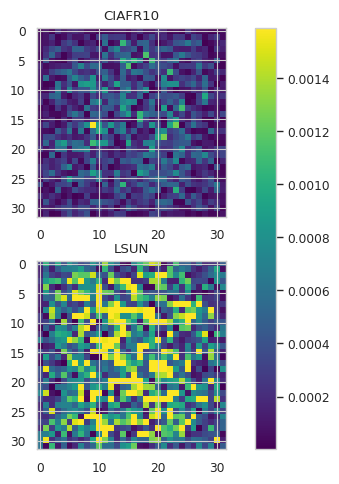

In [12]:
layer = "image"
wrt = "input"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1)
grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    norm=1,
)
ood_grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    ood_test_loader,
    device=device,
    norm=1,
)
plot_activation(np.abs(grads.numpy()), np.abs(ood_grads.numpy()), f"CIAFR10", f"{ood_dataset}")
plt.savefig(f'pngs/{model}/OOD_{ood_dataset}_{layer}_grad_wrt_input_activation.png', bbox_inches='tight')

register backward hook for layer1


100%|██████████| 1000/1000 [01:13<00:00, 13.66it/s]


register backward hook for layer1


100%|██████████| 1000/1000 [01:15<00:00, 13.22it/s]


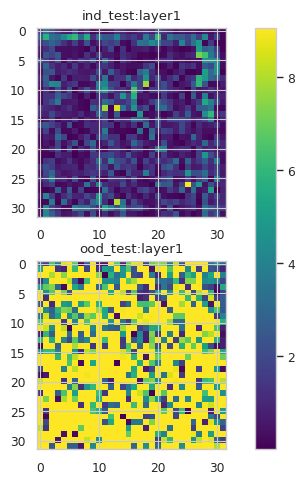

In [14]:
layer = "layer1"
wrt="input"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1)
grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    norm=1,
)
ood_grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    ood_test_loader,
    device=device,
    norm=1,
)
plot_activation(np.abs(grads.numpy()), np.abs(ood_grads.numpy()), f"ind_test:{layer}", f"ood_test:{layer}")
plt.savefig(f'pngs/{model}/{layer}_grad_wrt_input_activation.png', bbox_inches='tight')

register backward hook for layer2


100%|██████████| 1000/1000 [01:13<00:00, 13.61it/s]


register backward hook for layer2


100%|██████████| 1000/1000 [01:14<00:00, 13.35it/s]


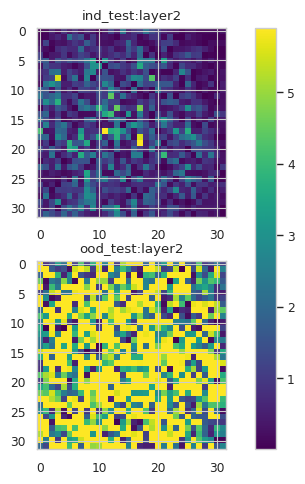

In [15]:
layer = "layer2"
wrt="input"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1)
grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    norm=1,
)
ood_grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    ood_test_loader,
    device=device,
    norm=1,
)
plot_activation(np.abs(grads.numpy()), np.abs(ood_grads.numpy()), f"ind_test:{layer}", f"ood_test:{layer}")
plt.savefig(f'pngs/{model}/{layer}_grad_wrt_input_activation.png', bbox_inches='tight')

In [16]:
layer = "layer3"
wrt="input"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1)
grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    norm=1,
)
ood_grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    ood_test_loader,
    device=device,
    norm=1,
)
plot_activation(np.abs(grads.numpy()), np.abs(ood_grads.numpy()), f"ind_test:{layer}", f"ood_test:{layer}")
plt.savefig(f'pngs/{model}/{layer}_grad_wrt_input_activation.png', bbox_inches='tight')

register backward hook for layer3


100%|██████████| 1000/1000 [01:13<00:00, 13.62it/s]


register backward hook for layer3


 28%|██▊       | 285/1000 [00:21<00:53, 13.28it/s]


KeyboardInterrupt: 

### GradNorm wrt Weight


Using downloaded and verified file: ../data/svhn/test_32x32.mat
svhn test:26032
register backward hook for image


100%|██████████| 1000/1000 [01:12<00:00, 13.73it/s]


register backward hook for image


100%|██████████| 1000/1000 [01:16<00:00, 13.15it/s]


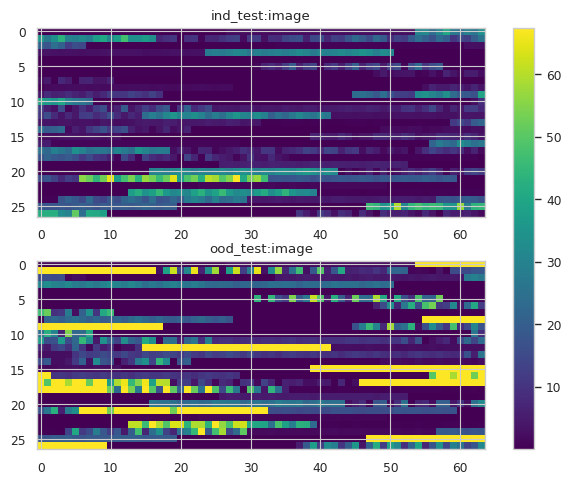

In [12]:
layer = "image"
wrt = "weight"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1)
grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    wrt=wrt,
    norm=1,
)
ood_grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    ood_test_loader,
    device=device,
    wrt=wrt,
    norm=1,
)
plot_activation(np.abs(grads.numpy()), np.abs(ood_grads.numpy()), f"ind_test:{layer}", f"ood_test:{layer}")
plt.savefig(f'pngs/{model}/{layer}_grad_wrt_{wrt}_activation.png', bbox_inches='tight')

Using downloaded and verified file: ../data/svhn/test_32x32.mat
svhn test:26032
register backward hook for layer1


100%|██████████| 1000/1000 [01:13<00:00, 13.64it/s]


register backward hook for layer1


100%|██████████| 1000/1000 [01:14<00:00, 13.47it/s]


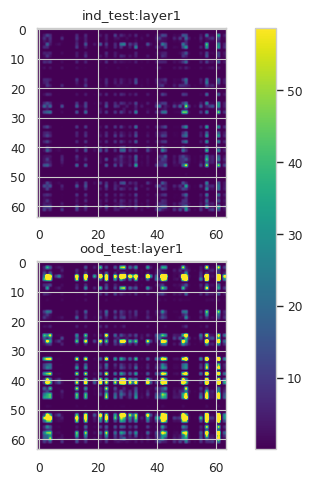

In [13]:
layer = "layer1"
wrt = "weight"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1)
grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    wrt=wrt,
    norm=1,
)
ood_grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    ood_test_loader,
    device=device,
    wrt=wrt,
    norm=1,
)
plot_activation(np.abs(grads.numpy()), np.abs(ood_grads.numpy()), f"ind_test:{layer}", f"ood_test:{layer}")
plt.savefig(f'pngs/{model}/{layer}_grad_wrt_{wrt}_activation.png', bbox_inches='tight')

Using downloaded and verified file: ../data/svhn/test_32x32.mat
svhn test:26032
register backward hook for layer2


100%|██████████| 1000/1000 [01:13<00:00, 13.58it/s]


register backward hook for layer2


100%|██████████| 1000/1000 [01:15<00:00, 13.21it/s]


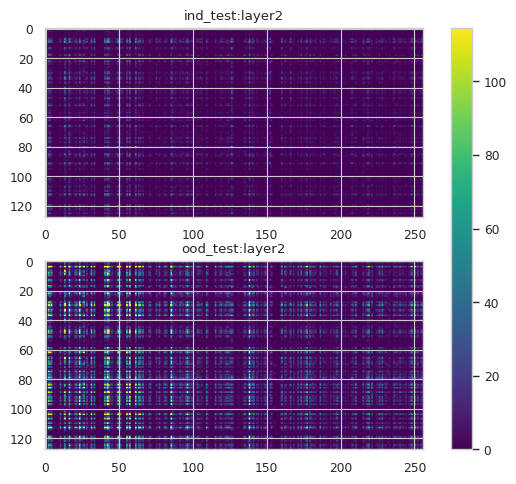

In [14]:
layer = "layer2"
wrt = "weight"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1)
grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    wrt = wrt,
    norm=1,
)
ood_grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    ood_test_loader,
    device=device,
    wrt=wrt,
    norm=1,
)
plot_activation(np.abs(grads.numpy()), np.abs(ood_grads.numpy()), f"ind_test:{layer}", f"ood_test:{layer}")
plt.savefig(f'pngs/{model}/{layer}_grad_wrt_{wrt}_activation.png', bbox_inches='tight')

Using downloaded and verified file: ../data/svhn/test_32x32.mat
svhn test:26032
register backward hook for layer3


100%|██████████| 1000/1000 [01:12<00:00, 13.71it/s]


register backward hook for layer3


100%|██████████| 1000/1000 [01:13<00:00, 13.69it/s]


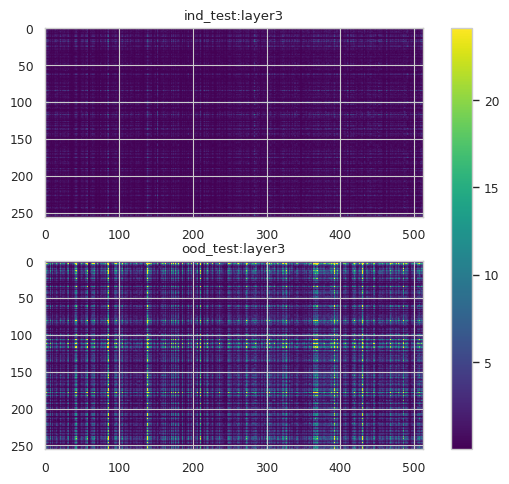

In [15]:
layer = "layer3"
wrt = "weight"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1)
grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    wrt=wrt,
    norm=1,
)
ood_grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    ood_test_loader,
    device=device,
    wrt=wrt,
    norm=1,
)
plot_activation(np.abs(grads.numpy()), np.abs(ood_grads.numpy()), f"ind_test:{layer}", f"ood_test:{layer}")
plt.savefig(f'pngs/{model}/{layer}_grad_wrt_{wrt}_activation.png', bbox_inches='tight')